In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import bz2
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import cPickle as pickle
import sys
import re
import seaborn as sns

from lang_map import code_lang_map
from pandas import DataFrame
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from collections import Counter


:0: FutureWarning: IPython widgets are experimental and may change in the future.


####Calculate the percentages from a pandas dataframe of letter counts and add the percentages as new columns to the given dataframe

In [2]:
def percentages(df):
    df2 = df.join(df.div(df['letters_count'], axis='index'), rsuffix='_perc')
    percs = [col for col in df2.columns if col.endswith('_perc')]
    return df2[percs]

####Count the number of times each character occurs in each language and grab the top 2000 from each of them

In [3]:
def get_top_letters():
    files = os.listdir('articles')
    top_letters = []    
    for f in files:        
        c = Counter()
        for article in parse('articles/'+f):
            c['articles_count'] += 1
            for letter in article['content']:
                c[letter] += 1
                c['letters_count'] += 1
        d = dict(c.most_common(2000))
        d['lang'] = os.path.splitext(f)[0]
        top_letters.append(d)
    return top_letters

####Parse data from the scrubbed wikipedia articles using regex and return a dictionary

In [4]:
def parse(filename):
    data = ""
    # regex pattern for scrubbing extracted wikipedia article 
    article_rgx = re.compile(
    r'<doc id="(?P<id>\d+)" url="(?P<url>[^"]+)" title="(?P<title>[^"]+)">\n(?P<content>.+)\n<\/doc>', re.S | re.U)
    with io.open(filename, 'r', encoding='utf8') as f:
        for line in f:
            #line = line.decode('utf-8')
            data += line
            if line.count('</doc>'):
                m = article_rgx.search(data)
                if m:
                    yield m.groupdict()
                data = ""

####Load the articles dictionary back from pickle

In [5]:
def load_data():
    f = open('letters2.pkl', 'rb')
    data = pickle.load(f)
    f.close()
    return data


####Save the articles dictionary into pickle

In [6]:
def dump_data():   
    top_letters = get_top_letters()  
    with open('letters2.pkl', 'wb') as handle:
        pickle.dump(top_letters, handle, protocol=2) 

In [7]:
data = load_data() 

In [8]:
df = DataFrame(data)
df.fillna(0, inplace=True)
df = df.set_index('lang')

In [9]:
df.head(7)

,,,!,"""",#,$,%,&,',(,...,ｍ,ｎ,ｐ,ｚ,～,｢,｣,､,￼,�
lang,,,,,,,,,,,,,,,,,,,,,
ar,83595,3852786,551,41465,94,138,3897,46,552,24992,...,0,0,0,0,0,0,0,0,0,0
bg,63516,2695979,430,27985,25,214,4013,134,701,26644,...,0,0,0,0,0,0,0,0,1,0
ca,94031,5139533,858,91075,148,101,4348,185,227845,42403,...,0,0,0,0,0,0,0,0,1,0
cs,73349,2981587,421,44276,42,57,4313,188,1423,39133,...,0,0,0,0,0,0,0,0,0,0
da,62393,2577203,308,55627,98,321,3096,729,6793,18269,...,0,0,0,0,0,0,0,0,0,0
de,158733,7488125,1118,144548,253,209,8685,1284,1826,69541,...,0,0,0,0,0,0,0,0,0,0
en,156617,9991721,2380,361454,1794,10915,9058,3350,127764,59698,...,0,0,0,0,0,0,0,0,0,1


In [10]:
df3 = percentages(df)
df3.values[np.isnan(df3.values)] = np.median(df3.values[~np.isnan(df3.values)])
df3.head(7)

,_perc,_perc,!_perc,"""_perc",#_perc,$_perc,%_perc,&_perc,'_perc,(_perc,...,ｍ_perc,ｎ_perc,ｐ_perc,ｚ_perc,～_perc,｢_perc,｣_perc,､_perc,￼_perc,�_perc
lang,,,,,,,,,,,,,,,,,,,,,
ar,0.003595,0.165686,0.000024,0.001783,0.000004,0.000006,0.000168,0.000002,0.000024,0.001075,...,0,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00
bg,0.003506,0.148829,0.000024,0.001545,0.000001,0.000012,0.000222,0.000007,0.000039,0.001471,...,0,0,0,0,0,0,0,0,5.520417e-08,0.000000e+00
ca,0.002943,0.160856,0.000027,0.002850,0.000005,0.000003,0.000136,0.000006,0.007131,0.001327,...,0,0,0,0,0,0,0,0,3.129786e-08,0.000000e+00
cs,0.003517,0.142946,0.000020,0.002123,0.000002,0.000003,0.000207,0.000009,0.000068,0.001876,...,0,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00
da,0.003642,0.150450,0.000018,0.003247,0.000006,0.000019,0.000181,0.000043,0.000397,0.001066,...,0,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00
de,0.002860,0.134936,0.000020,0.002605,0.000005,0.000004,0.000157,0.000023,0.000033,0.001253,...,0,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00
en,0.002512,0.160279,0.000038,0.005798,0.000029,0.000175,0.000145,0.000054,0.002049,0.000958,...,0,0,0,0,0,0,0,0,0.000000e+00,1.604116e-08


In [11]:
num_clusters = 4
palette = sns.color_palette('colorblind', num_clusters)

### Run KMeans clustering algorithm on letter percentages
#### KMeans automatically groups the data together based on similarity

In [12]:
est = KMeans(num_clusters, max_iter=30000)
est.fit(df3.values)
y_kmeans = est.predict(df3.values)

###Run Principal Component Analysis to reduce the number of columns from 10000 to 2

In [13]:
pca = PCA(n_components=2)
pca.fit(df3.values)
X_trans = pca.transform(df3.values)

###Plot the results

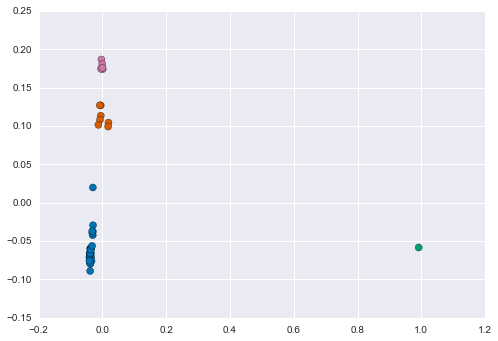

In [14]:
plt.scatter(X_trans[:, 0], X_trans[:, 1], c=[palette[y] for y in y_kmeans], s=50)

###Helper function for printing similarity distance details in clusters

In [15]:
def print_sim(dist, x, y, langs):
    print("{0} ({1}, {2})".format(dist, code_lang_map[langs[x]], code_lang_map[langs[y]]))

###Find the languages that are most similar

In [16]:
cluster_dfs = {}
cluster_langs = {}
cluster_distances = {}
langs = list(code_lang_map.keys())

In [17]:
for cluster_num in range(4):
    indexes = [i for i in range(y_kmeans.shape[0]) if y_kmeans[i] == cluster_num]
    cluster_langs[cluster_num] = [langs[i] for i in indexes]
    cluster_dfs[cluster_num] = df3.loc[cluster_langs[cluster_num], :]

    # Calculate pairwise distances and display
    print('Cluster #{0}'.format(cluster_num))
    
    cluster_distances[cluster_num] = pairwise_distances(cluster_dfs[cluster_num].values)
    n, m = cluster_distances[cluster_num].shape
    distances = set([])
    for i in range(n):
        for j in range(m):
            if i == j:
                continue
            distances.add((cluster_distances[cluster_num][i, j], tuple(sorted([i, j]))))
    for a in sorted(distances)[:20]:
        print_sim(a[0], a[1][0], a[1][1], langs)




Cluster #0
0.0134930582372 (Arabic, Persian)
0.0134930582373 (Arabic, Persian)
0.0369898458834 (Croatian, Finnish)
0.0382281250592 (Finnish, Czech)
0.0448013395959 (Croatian, German)
0.0485874241609 (Finnish, Kazakh)
0.050683479432 (Kazakh, Serbian)
0.0529485885806 (German, Finnish)
0.054227525429 (Vietnamese, Indonesian)
0.0548448505622 (Croatian, Kazakh)
0.05681091513 (German, Portuguese)
0.0588135128334 (Chinese, Dutch)
0.0591008339765 (Croatian, Czech)
0.0593707398764 (Croatian, Serbian)
0.0598196627665 (Finnish, Portuguese)
0.0604485418978 (Czech, Kazakh)
0.0606184195518 (Turkish, Spanish)
0.0607610860892 (Portuguese, Kazakh)
0.0620393067053 (Croatian, Portuguese)
0.0634290019112 (German, Spanish)
Cluster #1
Cluster #2
0.0475935968993 (Esperanto, Croatian)
0.0835127759886 (Chinese, Turkish)
0.103037792081 (Esperanto, Chinese)
0.110142539949 (Chinese, Croatian)
0.114259149551 (Bulgarian, Chinese)
0.117867182303 (Bulgarian, Turkish)
0.11799613275 (Croatian, Turkish)
0.118815437758 (